# **1. Configuración del Ambiente**

In [ ]:
!python -V
print('-----------')
!pip show Pandas | grep 'Name\|Version'
print('-----------')
!pip show Numpy | grep 'Name\|Version'
print('-----------')
!pip show Matplotlib | grep 'Name\|Version'

Python 3.10.12
-----------
Name: pandas
Version: 2.0.3
-----------
Name: numpy
Version: 1.25.2
-----------
Name: matplotlib
Version: 3.7.1


In [ ]:
!pip install yfinance

In [ ]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import yfinance as yf
from bs4 import BeautifulSoup

# Definimos las variables globales
global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision

# **2. Obtención de Datos**

In [ ]:
def importar_base_bitcoin():

  # Definimos las variables globales
  global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision

  # Extraer histórico de precios del Bitcoin en intervalos de 5 minutos para los últimos 7 días
  data = yf.download('BTC-USD', period='7d', interval='5m')
  df_bitcoin = pd.DataFrame(data)

In [ ]:
def extraer_tendencias():

  # Definimos las variables globales
  global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision

  # Realizar web scraping de CoinMarketCap para obtener el precio actual y la variación en la última hora
  url = 'https://coinmarketcap.com/'
  response = requests.get(url)
  soup = BeautifulSoup(response.content, features='lxml')

  # Buscamos la etiqueta que contiene el precio actual
  precio_tag = soup.find('div', {'class':'sc-500f568e-0 ejtlWy'})
  if precio_tag:
    precio_text = precio_tag.text.strip().replace('$','').replace(',','')
    precio_actual = float(precio_text)

  # Buscar la etiqueta que contiene la variación en la última hora
  variacion_tag = soup.find('span', {'class':'sc-6a54057-0 iEhQde'})
  if variacion_tag:
    variacion_text = variacion_tag.text.strip().replace('%','')
    variacion = float(variacion_text)
    # Determinar la tendencia
    if variacion < 0:
      tendencia = 'baja'
    else:
      tendencia = 'alta'

In [ ]:
# importar_base_bitcoin()
# extraer_tendencias()
# print('Precio actual del Bitcoin: ',precio_actual)
# print('Tendencia: ', tendencia)

[*********************100%%**********************]  1 of 1 completed


Precio actual del Bitcoin:  71695.6
Tendencia:  alta


# **3. Limpieza de Datos**

In [ ]:
def limpieza_datos():

  # Definimos las variables globales
  global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision

  # Crea una copia de la base 'df_bitcoin'
  df_bitcoin_limpio = df_bitcoin.copy()

  # Identifica duplicados en el índice y trátalos para quedarte con sólo índices únicos
  df_bitcoin_limpio = df_bitcoin_limpio[~df_bitcoin_limpio.index.duplicated(keep='first')]

  # Luego busca por valores nulos en la columna Close y trátalos.
  df_bitcoin_limpio['Close'].fillna(method='ffill', inplace=True)

  # Verifica que todos los registros de la base tengan un 'Volume' de transacción mayor a 0, caso contrário, elimínalos
  df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] > 0]

  # Deberás identificar y eliminar los outliers en el precio del Bitcoin, columna Close, utiliza un gráfico de boxplot para identificarlos.
  # Gráfico de boxplot
  fig, ax = plt.subplots()
  ax.boxplot(df_bitcoin_limpio['Close'])
  ax.set_title("Diagrama de Cajas de: Close")
  plt.show()
  # Identificamos y eliminamos los outliers de 'Close'
  Q1 = df_bitcoin_limpio['Close'].quantile(0.25)
  Q3 = df_bitcoin_limpio['Close'].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  # Filtra o selecciona únicamente los registros cuyo precio(Close) se encuentren entre el 1er cuartil(Q1) y el 3er cuartil(Q3) del boxplot.
  df_bitcoin_limpio = df_bitcoin_limpio[(df_bitcoin_limpio['Close'] > lower_bound) & (df_bitcoin_limpio['Close'] < upper_bound)]

  # Finalmente, calcula el precio promedio(Close) de esta selección y guárdala en la variable media_bitcoin.
  media_bitcoin = df_bitcoin_limpio['Close'].mean()

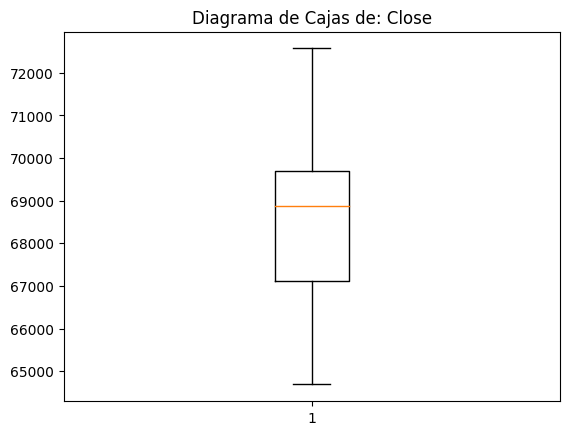

In [ ]:
# limpieza_datos()

# **4. Toma de Decisiones**

In [ ]:
def tomar_decisiones():

  # Definimos las variables globales
  global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision

  # Si el precio actual es mayor/igual que el precio promedio y la tendencia es de baja, entonces guarda el valor ‘Vender’
  if (precio_actual >= media_bitcoin) & (tendencia == 'baja'):
    algoritmo_decision = 'Vender'
  elif (precio_actual < media_bitcoin) & (tendencia == 'alta'):
    algoritmo_decision = 'Comprar'
  else:
    algoritmo_decision = 'Esperar'

  print(algoritmo_decision)

In [ ]:
# tomar_decisiones()

Esperar


# **5. Visualización**

In [ ]:
def visualizacion():

  # Definimos las variables globales
  global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision

  # Adiciona una nueva columna (Promedio) al dataframe original 'df_bitcoin' y almacena el valor de nuestra variable 'media_bitcoin'.
  df_bitcoin['Promedio'] = media_bitcoin

  # Configura el tamaño del gráfico en una proporción de 16x5
  plt.figure(figsize=(16,5))

  # Adiciona un título al gráfico.
  plt.title('Precio del Bitcoin vs Promedio')

  # Usando el método plot(), dibuja una línea en el gráfico, con los datos del índice y la columna 'Close' de la base df_bitcoin.
  plt.plot(df_bitcoin.index, df_bitcoin['Close'], label='Precio del Bitcoin')

  # Usando el método plot(), dibuja una línea en el gráfico, con los datos del índice y la columna 'Promedio' de la base df_bitcoin.
  plt.plot(df_bitcoin.index, df_bitcoin['Promedio'], label= 'Promedio', linestyle='--')

  # Usando el método annotate(), muestra un mensaje dentro del gráfico con la decisión calculada del algoritmo
  plt.annotate(f'{algoritmo_decision}', (df_bitcoin.index[-1], df_bitcoin['Close'].max()), xytext=(-50,-50), textcoords='offset points', fontsize=20, color='red', ha='left', va='top')

  # Leyenda el gráfico
  plt.legend()

  # Mostrar el gráfico
  plt.show()

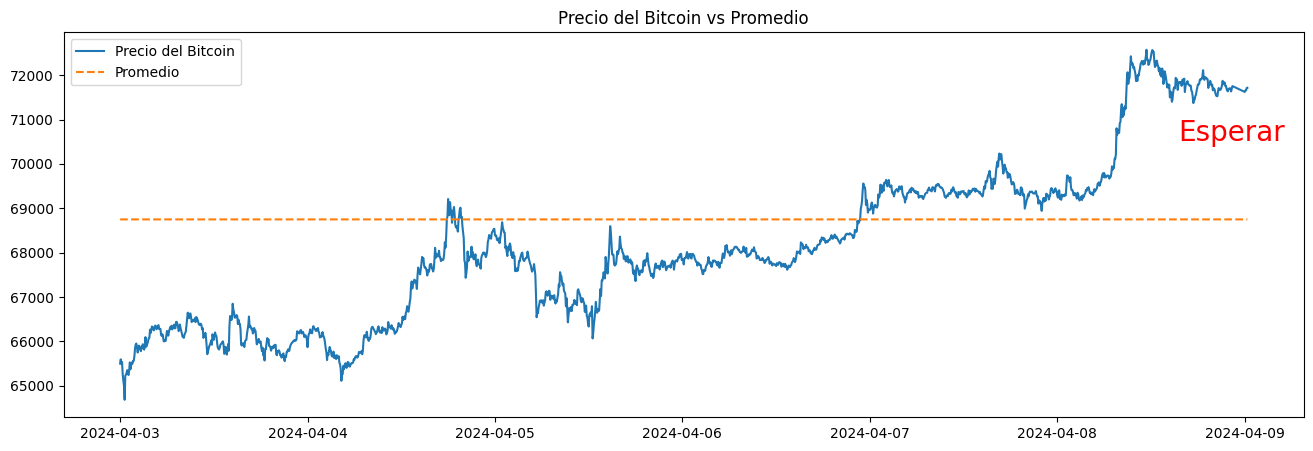

In [ ]:
# visualizacion()

# **6. Automatización**

[*********************100%%**********************]  1 of 1 completed


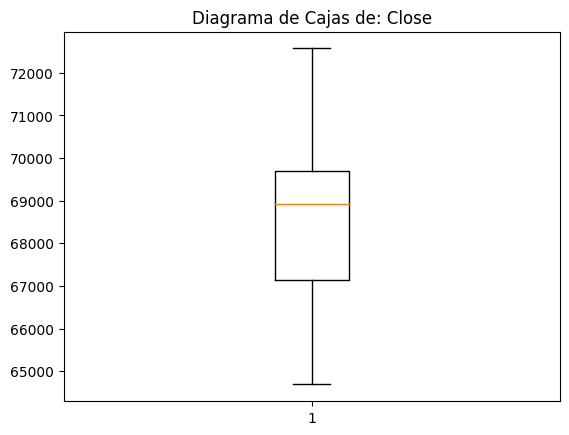

Esperar


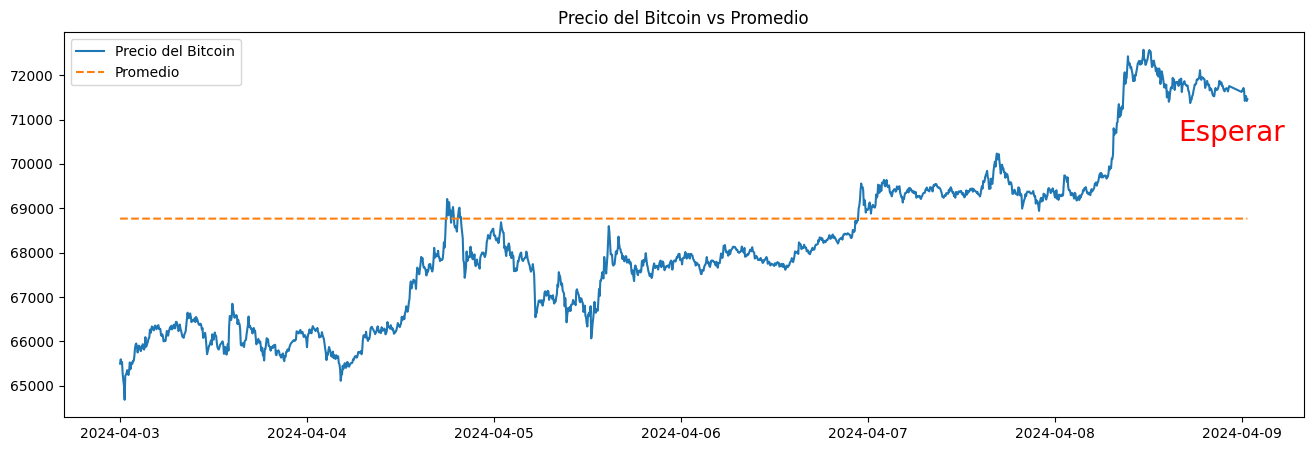

KeyboardInterrupt: 

In [ ]:
# Importa el método 'clear_output()', este método nos permite borrar los resultados de la pantalla antes de imprimir un nuevo gráfico,
# y así evitar tener más de un gráfico en la pantalla, impórtalo de la siguiente forma:
from IPython.display import clear_output

# Importa también la biblioteca ‘time’ de la siguiente forma: 'import time',
# utilizaremos su método time.sleep(300) para interrumpir la ejecución del código cada 300 segundos o 5 minutos.
import time

# Finalmente construiremos un loop infinito para ejecutar permanentemente y en intervalos de 5 minutos,
# las funciones que hemos construído en los pasos 2 al 5 de nuestro proyecto, de la siguiente forma:

while(True):
  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decisiones()
  visualizacion()
  time.sleep(300)